# Deep Learning Exam

Author: Matteo Caviglia

ID: 513026

## Project Outline
[**Section 0**](#task0): Imports, Data Loading

[**Section 1**](#task1): Model Choice

[**Section 2**](#task2): Input

[**Section 3**](#task3): Output

[**Section 4**](#task4): Loss

[**Section 5**](#task5): Model Configuration

[**Section 6**](#task6): Model Evaluation

### Notes

There are some differences between this project and the initial design provided in the written exam. These differences are mostly a consequence of how Google Colab poses some limitation on its computational units.

The whole part of Hyperparameter Tuning was not compiling in due time and many trials were made.
Also, some HyperParameters that were set to tune have been ignored, that decision was made in order to try and simplify the function to make it compile faster.

Also, I have somewhere helped myself with some AI tools make the code more readable and to fill in some comments.

<a name='task0'></a>
## 0. Imports, Data Loading

In [ ]:
!pip install keras_tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 885.5 kB/s eta 0:00:00


In [ ]:
import os
import random
import pickle as pk
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, f1_score

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers, initializers, utils
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, Activation, Add
)
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.regularizers import l2
from keras.initializers import HeNormal, HeUniform

from keras_tuner import HyperModel, RandomSearch, Objective, Hyperband, SklearnTuner

import warnings


In [ ]:
# **Corrected ZIP data URL from GitHub - raw file URL needed**
zip_url = "https://raw.githubusercontent.com/22cav/DL_Data/18b1f92188b6c133ec6ec3856c41114925afd44e/input_data.zip"

# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)

# Unzip the folder
target_folder = "temp"

# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

#Then use the following lines to read it:
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

In [ ]:
print(images.shape)
print(labels.shape)
print(bboxes.shape)

(186, 227, 227, 3)
(186,)
(186, 4)


In [ ]:
def plot_image_with_bbox(image, bbox, label):
    # Check the data type of the image and clip values to valid ranges
    if image.dtype == np.float32 or image.dtype == np.float64:
        # For floating-point images, ensure values are in the range [0, 1]
        image = np.clip(image, 0, 1)
    elif image.dtype == np.uint8:
        # For uint8 images, ensure values are in the range [0, 255]
        image = np.clip(image, 0, 255)
    else:
        # Raise an error if the image data type is not supported
        raise ValueError("Unsupported image data type. Expected float32, float64, or uint8.")

    # Convert normalized bounding box coordinates (assuming range [0, 1]) to image coordinates
    x1, y1, x2, y2 = bbox * 227
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)  # Convert coordinates to integers
    width = x2 - x1  # Calculate the width of the bounding box
    height = y2 - y1  # Calculate the height of the bounding box

    # Print the bounding box coordinates for debugging purposes
    print(f"Bounding box coordinates: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1)
    ax.imshow(image)  # Display the image

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)  # Add the bounding box patch to the axis
    # Add a label above the bounding box
    plt.text(x1, y1 - 10, label, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')  # Turn off the axis
    plt.show()  # Display the plot


<a name='task1'></a>
## 1. Model

We are going to use the Convolutional Architecture for our Models, which is based on Convolutional Layers.

I am also going to use the Inception layer, a special kind of Convolutional layer, that has the capability of performing multiple convolutions with different kernel sizes at the same time.

We are gonna use such layer to compare our Standard Models with an Higher Level Architecture. A layer of such architecture can be defined using the following function.

In [ ]:
def inception_block(inputs, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(inputs)

    # 3x3 convolution branch
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 5x5 convolution branch
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # 3x3 max pooling branch
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])

    return output

<a name='task2'></a>
## 2. Input

First, we scale the data to our wanted ranges. We can obtain that by simply performing mathematical operations on the data that contains them.

In [ ]:
### We want our values to be in the range [0,1]

images_scaled = images / 255.0
bbox_scaled = (bboxes-1) / 226.0

print(f"Min and max pixel values: {images_scaled.min()}, {images_scaled.max()}")
print(f"Min and max bbox values: {bbox_scaled.min()}, {bbox_scaled.max()}")
print(f"Shape of images_scaled: {images_scaled.shape}")
print(f"Shape of bbox_scaled: {bbox_scaled.shape}")

Min and max pixel values: 0.0, 1.0
Min and max bbox values: 0.0, 1.0
Shape of images_scaled: (186, 227, 227, 3)
Shape of bbox_scaled: (186, 4)


Now we want to perform some kind of Data Augmentation to our Images. In our case we are simply going to flip the images on the vertical axis. We are going to define a layer for that.

In [ ]:
# Import the necessary TensorFlow module
import tensorflow as tf

# Define a custom data augmentation layer that inherits from tf.keras.layers.Layer
class DataAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        # Call the constructor of the parent class
        super(DataAugmentationLayer, self).__init__(*args, **kwargs)

    def call(self, images, bboxes):
        # Apply random horizontal flip to images and bounding boxes
        images, bboxes = self.random_flip(images, bboxes)

        # Apply random brightness adjustment to images
        images = tf.image.random_brightness(images, max_delta=0.1)

        # Return the augmented images and bounding boxes
        return images, bboxes

    def random_flip(self, images, bboxes):
        # Randomly flip images horizontally
        flipped_images = tf.image.random_flip_left_right(images)

        # Determine which images were flipped by comparing with the original images
        flip_condition = tf.not_equal(images, flipped_images)
        flip_condition = tf.reduce_any(flip_condition, axis=[1, 2, 3])

        # Reshape the flip condition to be compatible with bounding boxes
        flip_condition = tf.reshape(flip_condition, [-1, 1])

        # Update bounding boxes for flipped images
        bboxes = tf.where(
            flip_condition,
            tf.concat([
                1 - bboxes[..., 2:3],  # Flip  coordinate
                bboxes[..., 1:2],      # y coordinate remains the same
                1 - bboxes[..., 0:1],
                bboxes[..., 3:4]
            ], axis=-1),
            bboxes  # If not flipped, keep the bounding boxes unchanged
        )

        return flipped_images, bboxes

data_augmentation = DataAugmentationLayer()


Bounding box coordinates: x1=7, y1=48, x2=212, y2=213


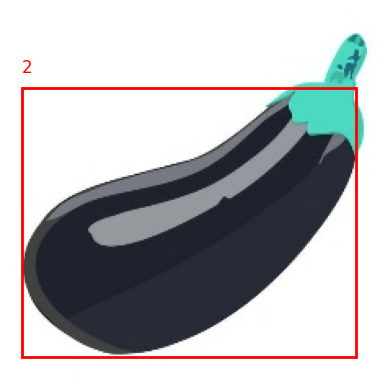


------------------

Bounding box coordinates: x1=14, y1=48, x2=219, y2=213


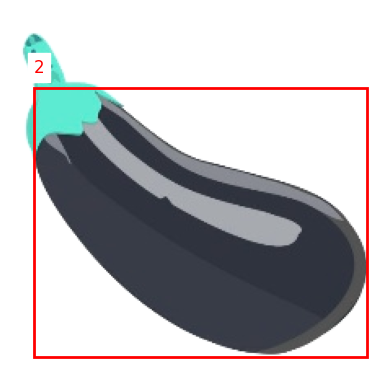

In [ ]:
### Display the effects of the data augmentation layer

n = random.randint(0, len(images_scaled)-1)
example_image = images_scaled[n]
example_bbox = bbox_scaled[n]
example_label = labels[n]

augmented_image, augmented_bbox = data_augmentation(tf.expand_dims(example_image, axis=0), tf.expand_dims(example_bbox, axis=0))

plot_image_with_bbox(example_image, example_bbox, example_label)
print("\n------------------\n")
plot_image_with_bbox(augmented_image[0], augmented_bbox[0], example_label)

Now we want to divide our initial, non scaled data in Training and Testing datasets. We could also consider adding a Validation Split, but in our case the data is limited, and we want our model to have a sufficient amount of data. Also, we want enough Testing data to draw some confident conclusions.

In [ ]:
### Divide our dataset into Training and Testing

images_scaled = np.array(images_scaled)
bbox_scaled = np.array(bbox_scaled)
labels = np.array(labels)

train_images, test_images, train_bboxes, test_bboxes, train_labels, test_labels = train_test_split(
    images_scaled, bbox_scaled, labels, test_size=0.2, random_state=22
)

print(len(train_images), len(test_images))

148 38


Here we define a function that will preprocess our data, augmenting the images and defining two clear datasets, already divided into batches.

In [ ]:
def load_and_preprocess_data(images, bboxes, labels, batch_size, augment=False):
    # Conditionally augment the data
    def augment_conditionally(image, bbox, label):
        if augment:
            # Apply data augmentation augment is True
            image, bbox = data_augmentation(tf.expand_dims(image, axis=0), tf.expand_dims(bbox, axis=0))
            # Remove the added dimension after augmentation
            image = tf.squeeze(image, axis=0)
            bbox = tf.squeeze(bbox, axis=0)
        return image, bbox, label

    # Create a tf.data.Dataset object from the images, bounding boxes, and labels
    dataset = tf.data.Dataset.from_tensor_slices((images, bboxes, labels))
    # Apply the augment_conditionally function to each element in the dataset
    dataset = dataset.map(augment_conditionally, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Adjust the dataset format to have images and a dictionary containing bounding boxes and adjusted labels
    dataset = dataset.map(lambda img, bbox, label: (img, {'bbox': bbox, 'label': label-1}), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the dataset, batch it, and prefetch for better performance
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
### Apply data augmentation and divide the datasets into batches

train_dataset = load_and_preprocess_data(train_images, train_bboxes, train_labels, batch_size=2, augment=True)
test_dataset = load_and_preprocess_data(test_images, test_bboxes, test_labels, batch_size=1)

<a name='task3'></a>
## 3. Output


We want our output layers to match our wanted outputs. So, for the Label Prediction we want a Dense layer with as many hidden units as classes (3 in our case) and softmax as our activation function.

For the Bounding Box prediction, we want to predict the coordinates for 2 points. These points have their coordinates expressed in the range [0, 1] thanks to the pre-processing step. So it will be enough to have 4 hidden units with a sigmoid as an activation function.

In [ ]:
### Define our 2 layers that will act as ouput layers for both of our tasks
# Classification: Label Prediction / BoundingBox: Bounding Box prediction

class ClassificationOutputLayer(tf.keras.layers.Layer):
  def __init__(self, num_classes = 3, *args, **kwargs):
    super(ClassificationOutputLayer, self).__init__(*args, **kwargs)
    self.num_classes = num_classes
    self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    return self.dense(inputs)

class BoundingBoxOutputLayer(tf.keras.layers.Layer):
  def __init__(self, *args, **kwargs):
    super(BoundingBoxOutputLayer, self).__init__(*args, **kwargs)
    self.dense = tf.keras.layers.Dense(4, activation='sigmoid')

  def call(self, inputs):
    return self.dense(inputs)

<a name='task4'></a>
## 4. Loss

Here we define our double output model's loss functions.
To do so, we define a dictionary with a name that characterizes our two outputs, in this case "label" and "bbox".

We use "Sparse Categorical Cross Entropy" for our loss when predicting the class, while we use "Mean Squared Error" for our Regression-like task of predicting coordinates.

In [ ]:
### We define the Loss functions that we will use in our model(s)
### We also define the metrics. They will help us evaluate the model in runtime.

loss_dict = {
        "label": tf.keras.losses.sparse_categorical_crossentropy,
        "bbox": tf.keras.losses.MeanSquaredError()
    }
metric_dict =  {
        "label": 'accuracy',
        "bbox": 'mse'
    }

<a name='task5'></a>
## 5. Model Architecture

As a first step, we want to make sure that our model works as intended and we do so by creating a baseline model.

In [ ]:
# Define the input shape
input_shape = (227, 227, 3)
input = Input(shape=input_shape, dtype='float32', name="input")

# Add convolutional layers with ReLU activation
x = Conv2D(64, kernel_size=(3,3), padding="same", activation='relu', name="cnn")(input)
x = Conv2D(32, kernel_size=(3,3), padding="same", activation='relu')(x)
x = Conv2D(16, kernel_size=(2,2), padding="same", activation='relu')(x)

# Add max pooling layer
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor
x = Flatten()(x)

# Add a dense layer
x = Dense(32, activation='relu')(x)

# Define custom output layers for classification and bounding box prediction
out_class = ClassificationOutputLayer()(x)
out_bbox = BoundingBoxOutputLayer()(x)

# Create and compile the model
base_model = tf.keras.Model(inputs=input, outputs={'label': out_class, 'bbox': out_bbox})
base_model.compile(optimizer='adam', loss=loss_dict, metrics=metric_dict)

In [ ]:
base_model.fit(train_dataset, epochs=10);

Epoch 1/10
74/74 [==============================] - 13s 17ms/step - loss: 1.3857 - bounding_box_output_layer_loss: 0.0882 - classification_output_layer_loss: 1.2975 - bounding_box_output_layer_mse: 0.0882 - classification_output_layer_accuracy: 0.3176
Epoch 2/10
74/74 [==============================] - 2s 20ms/step - loss: 1.1568 - bounding_box_output_layer_loss: 0.0580 - classification_output_layer_loss: 1.0987 - bounding_box_output_layer_mse: 0.0580 - classification_output_layer_accuracy: 0.3649
Epoch 3/10
74/74 [==============================] - 2s 22ms/step - loss: 1.1176 - bounding_box_output_layer_loss: 0.0514 - classification_output_layer_loss: 1.0662 - bounding_box_output_layer_mse: 0.0514 - classification_output_layer_accuracy: 0.4257
Epoch 4/10
74/74 [==============================] - 3s 27ms/step - loss: 1.1829 - bounding_box_output_layer_loss: 0.0878 - classification_output_layer_loss: 1.0951 - bounding_box_output_layer_mse: 0.0878 - classification_output_layer_accuracy: 0.

### HyperParameter Tuning

This part is about hyperparameter tuning. My initial idea was to create and optimize on two different model generating functions, one for a Standard CNN architecture and the other one for an Inception-like architecture.

Although, because of computational limitations, I will not make proper use of the following functions, but I will only show their functionality. For evaluation, I will use two placeholder models with values defined by myself, in order to show some results.


In [ ]:
def create_model(hp, input_shape=(227, 227, 3), num_classes=3):
    # Input layer
    inputs = Input(shape=input_shape, dtype='float32', name="input")
    x = inputs

    # Add convolutional layers based on hyperparameters
    num_cnn_layers = hp.Int('num_cnn_layers', min_value=2, max_value=4)
    for i in range(num_cnn_layers):
        disc = i * 16
        num_filters = hp.Int(f'num_filters_{i}', min_value=64-disc, max_value=80-disc, step=16)
        kernel_size_str = hp.Choice(f'kernel_size_{i}', ['2x2', '3x3'])
        kernel_size = tuple(map(int, kernel_size_str.split('x')))
        x = Conv2D(
            filters=num_filters,
            kernel_size=kernel_size,
            padding="same",
            activation='relu',
            kernel_regularizer=l2(1e-4),
            kernel_initializer=HeUniform(),
            name=f"cnn_{i}"
        )(x)

    # Add pooling, flattening, and dense layers based on hyperparameters
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2)
    for i in range(num_dense_layers):
        num_dense_units = hp.Int(f'num_dense_units_{i}', min_value=32, max_value=64, step=16)
        x = Dense(
            units=num_dense_units,
            activation='relu',
            kernel_regularizer=l2(1e-4),
            kernel_initializer=HeUniform()
        )(x)

    # Add dropout layer based on hyperparameters
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.05)
    x = Dropout(rate=dropout_rate)(x)

    # Output layers
    output_class = ClassificationOutputLayer()(x)
    output_bbox = BoundingBoxOutputLayer()(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs={'label': output_class, 'bbox': output_bbox})
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_dict,
        metrics=metric_dict
    )

    return model

In [ ]:
warnings.filterwarnings("ignore")

class MyHyperModel(HyperModel):
    def build(self, hp):
        return create_model(hp)

# Configure the hyperparameter tuner
tuner = RandomSearch(
    MyHyperModel(),
    max_trials=1,  # Set the number of trials for hyperparameter search
    objective=Objective('val_loss', direction="min"),  # Optimize for minimum validation loss
    executions_per_trial=1,  # Number of executions per trial
    directory='hyperparameter_tuning',  # Directory for storing results
    project_name='model_tuning'  # Project name
)

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if no improvement for 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# Perform hyperparameter search
tuner.search(train_dataset, validation_data=test_dataset, epochs=10, callbacks=[early_stopping])

# Retrieve the best model
best_cnn_model = tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 00m 35s]
val_loss: 0.17337603867053986

Best val_loss So Far: 0.17337603867053986
Total elapsed time: 00h 00m 35s


In [ ]:
def create_inception_model(hp, input_shape=(227, 227, 3), num_classes=3):
    # Input layer
    inputs = Input(shape=input_shape, dtype='float32', name="input")
    x = inputs

    # Convolutional layer with hyperparameter choices
    num_filters = hp.Int('num_filters', min_value=32, max_value=64, step=16)
    kernel_size_str = hp.Choice('kernel_size', ['2x2', '3x3'])
    kernel_size = tuple(map(int, kernel_size_str.split('x')))
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        padding="same",
        activation='relu',
        kernel_regularizer=l2(1e-4),
        kernel_initializer=HeUniform(),
        name="cnn"
    )(x)

    # Inception block with hyperparameter choices
    filters_1x1 = hp.Int('filters_1x1', min_value=16, max_value=24, step=8)
    filters_3x3_reduce = hp.Int('filters_3x3_reduce', min_value=16, max_value=24, step=8)
    filters_3x3 = hp.Int('filters_3x3', min_value=32, max_value=48, step=16)
    filters_5x5_reduce = hp.Int('filters_5x5_reduce', min_value=8, max_value=16, step=8)
    filters_5x5 = hp.Int('filters_5x5', min_value=16, max_value=32, step=16)
    filters_pool_proj = hp.Int('filters_pool_proj', min_value=8, max_value=16, step=8)
    x = inception_block(
        x,
        filters_1x1,
        filters_3x3_reduce,
        filters_3x3,
        filters_5x5_reduce,
        filters_5x5,
        filters_pool_proj
    )

    # Pooling, flattening, and dense layers with hyperparameter choices
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2)
    for i in range(num_dense_layers):
        num_dense_units = hp.Int(f'num_dense_units_{i}', min_value=32, max_value=64, step=32)
        x = Dense(
            units=num_dense_units,
            activation='relu',
            kernel_regularizer=l2(1e-4),
            kernel_initializer=HeUniform()
        )(x)

    # Dropout layer with hyperparameter choice
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.05)
    x = Dropout(rate=dropout_rate)(x)

    # Output layers
    output_class = ClassificationOutputLayer()(x)
    output_bbox = BoundingBoxOutputLayer()(x)

    # Create and compile the model with learning rate hyperparameter
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model = tf.keras.Model(inputs=inputs, outputs={'label': output_class, 'bbox': output_bbox})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_dict,
        metrics=metric_dict
    )

    return model

In [ ]:
warnings.filterwarnings("ignore")

# Define a custom hypermodel class
class MyHyperInceptionModel(HyperModel):
    def build(self, hp):
        return create_inception_model(hp)  # Build model using create_inception_model function

# Configure the RandomSearch tuner for hyperparameter optimization
inception_tuner = RandomSearch(
    MyHyperInceptionModel(),
    max_trials=1,  # Number of trials for hyperparameter search
    objective=Objective('val_loss', direction="min"),  # Optimize for minimum validation loss
    executions_per_trial=1,  # Number of executions per trial
    directory='hyperparameter_inception_tuning',  # Directory to store results
    project_name='inception_model_tuning'  # Project name
)

# Perform hyperparameter search
inception_tuner.search(train_dataset, validation_data=test_dataset, epochs=10, callbacks=[early_stopping])

# Retrieve the best model found by the tuner
best_inc_model = inception_tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 01m 28s]
val_loss: 1.2027934789657593

Best val_loss So Far: 1.2027934789657593
Total elapsed time: 00h 01m 28s


Because of our limited resources and the limited iterations of the RandomSearch algorithms, probably we are not able to find an optimal solution for our hyperparameters. Although, letting the algorithm run for an extended period of time will give us a much better solution.


### Models defined for Evaluation

In [ ]:
# Define input shape for the CNN model
input_shape = (227, 227, 3)
input_layer = Input(shape=input_shape, dtype='float32', name="input")
x = input_layer

# Convolutional layers with ReLU activation, regularization, and initialization
x = Conv2D(128, kernel_size=(3,3), padding="same", activation='relu', name="cnn1", kernel_regularizer=l2(1e-4), kernel_initializer=HeUniform())(x)
x = Conv2D(64, kernel_size=(3,3), padding="same", activation='relu', name="cnn2", kernel_regularizer=l2(1e-4), kernel_initializer=HeUniform())(x)
x = Conv2D(32, kernel_size=(2,2), padding="same", activation='relu', name="cnn3", kernel_regularizer=l2(1e-4), kernel_initializer=HeUniform())(x)

# Max pooling layer
x = MaxPooling2D(pool_size=(3, 3))(x)

# Flatten layer to convert 2D features into 1D
x = Flatten()(x)

# Dropout layer to prevent overfitting
x = Dropout(0.1)(x)

# Dense (fully connected) layer with ReLU activation
x = Dense(64, activation='relu')(x)

# Output layers for classification and bounding box prediction
output_class = Dense(3, activation='softmax', name='label')(x)
output_bbox = Dense(4, activation='sigmoid', name='bbox')(x)

# Create the CNN model with specified inputs and outputs
cnn_model = tf.keras.Model(inputs=input_layer, outputs={'label': output_class, 'bbox': output_bbox})

# Compile the model with Adam optimizer, loss function dictionary, and metrics
cnn_model.compile(optimizer='adam',
                  loss=loss_dict,
                  metrics=metric_dict)

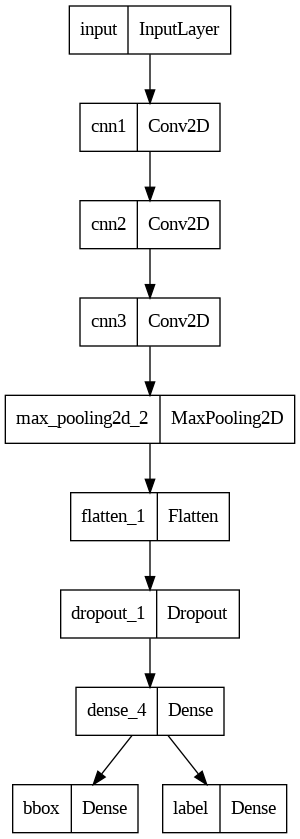

In [ ]:
plot_model(cnn_model)

In [ ]:
# Define input layer for the Inception model
inputs = Input(shape=(227, 227, 3), dtype='float32', name="input")
x = inputs

# Convolutional layer with ReLU activation, regularization, and initialization
x = Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    activation='relu',
    kernel_regularizer=l2(1e-4),
    kernel_initializer=HeUniform(),
    name="cnn"
)(x)

# Inception block function call with specified parameters
x = inception_block(x, 24, 16, 48, 8, 16, 8)

# Max pooling layer to reduce spatial dimensions
x = MaxPooling2D(pool_size=(3, 3))(x)

# Flatten layer to convert 2D features into 1D
x = Flatten()(x)

# Dropout layer to prevent overfitting
x = Dropout(rate=0.1)(x)

# Dense layer with ReLU activation and regularization
x = Dense(
    units=32,
    activation='relu',
    kernel_regularizer=l2(1e-4),
    kernel_initializer=HeUniform()
)(x)

# Output layers for classification and bounding box prediction
output_class = Dense(3, activation='softmax', name='label')(x)
output_bbox = Dense(4, activation='sigmoid', name='bbox')(x)

# Create the Inception model with specified inputs and outputs
inc_model = Model(inputs=inputs, outputs={'label': output_class, 'bbox': output_bbox})

# Compile the model with Adam optimizer, learning rate, loss function dictionary, and metrics
inc_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss_dict,
    metrics=metric_dict
)


Inception Model Graph:


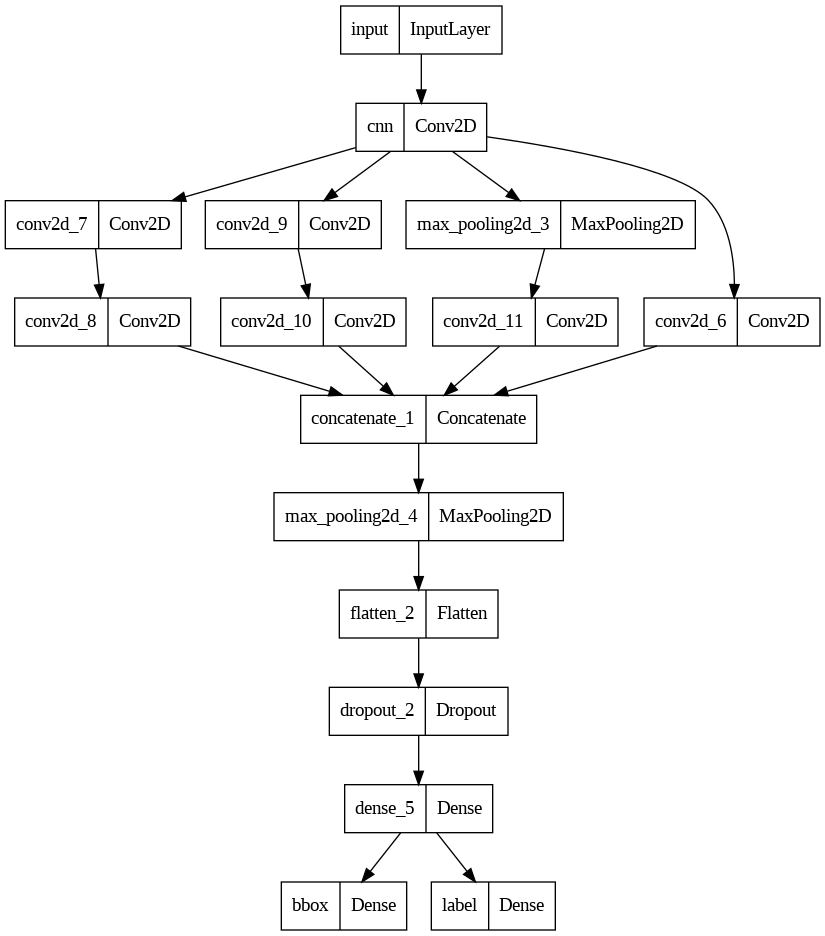

In [ ]:
print("Inception Model Graph:")
plot_model(inc_model)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=7,  # Stop if no improvement for 7 epochs
    restore_best_weights=True
)

# Fit the models
inc_model.fit(train_dataset, epochs=25, callbacks=[early_stopping])
cnn_model.fit(train_dataset, epochs=25, callbacks=[early_stopping]);

Epoch 1/25
74/74 [==============================] - 7s 24ms/step - loss: 7.8651 - bbox_loss: 0.2327 - label_loss: 7.6045 - bbox_mse: 0.2327 - label_accuracy: 0.4392
Epoch 2/25
74/74 [==============================] - 2s 22ms/step - loss: 0.5073 - bbox_loss: 0.0858 - label_loss: 0.3839 - bbox_mse: 0.0858 - label_accuracy: 0.8986
Epoch 3/25
74/74 [==============================] - 2s 22ms/step - loss: 0.4761 - bbox_loss: 0.0701 - label_loss: 0.3618 - bbox_mse: 0.0701 - label_accuracy: 0.9054
Epoch 4/25
74/74 [==============================] - 2s 21ms/step - loss: 0.5384 - bbox_loss: 0.0738 - label_loss: 0.4163 - bbox_mse: 0.0738 - label_accuracy: 0.8851
Epoch 5/25
74/74 [==============================] - 2s 22ms/step - loss: 0.2533 - bbox_loss: 0.0594 - label_loss: 0.1430 - bbox_mse: 0.0594 - label_accuracy: 0.9797
Epoch 6/25
74/74 [==============================] - 2s 25ms/step - loss: 0.1675 - bbox_loss: 0.0494 - label_loss: 0.0662 - bbox_mse: 0.0494 - label_accuracy: 0.9865
Epoch 7/25

<a name='task6'></a>
## 6. Model Evaluation

Now we have 2 models trained on the same data and with the same number of epochs, one defined with a standard Convolutional Architecture, while the other uses an Inception Block to further analyze the data.

Let's evaluate the both of them.

In [ ]:
def evaluate_model(model, test_dataset):
    # Evaluate the model on the test dataset
    results = model.evaluate(test_dataset, verbose=0)

    # Get the metric names from the model
    metric_names = model.metrics_names

    # Compile the results into a dictionary
    results_dict = dict(zip(metric_names, results))

    # Print the results dictionary
    print(f"Test Results: {results_dict}")

    return results_dict

In [ ]:
print("Standard CNN Model Evaluation:")
evaluate_model(cnn_model, test_dataset)

print("\n------------------\n")

print("Inception Model Evaluation:")
evaluate_model(inc_model, test_dataset);

Standard CNN Model Evaluation:
Test Results: {'loss': 1.449462890625, 'bbox_loss': 0.03958822414278984, 'label_loss': 1.3708373308181763, 'bbox_mse': 0.03958822414278984, 'label_accuracy': 0.9210526347160339}

------------------

Inception Model Evaluation:
Test Results: {'loss': 0.08192644268274307, 'bbox_loss': 0.0297851599752903, 'label_loss': 0.010594239458441734, 'bbox_mse': 0.0297851599752903, 'label_accuracy': 1.0}


### Label Prediction Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Initialize lists to store true labels and test data
y_true = []
X_test = []

# Iterate through the test dataset to extract true labels and images
for X, y in test_dataset:
    y_true.append(y['label'].numpy())  # Append true labels
    X_test.append(X.numpy())  # Append images

# Concatenate the lists into numpy arrays
X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

# Predict labels using the CNN model
preds_cnn = cnn_model.predict(X_test, verbose=0)['label']
preds_cnn = np.argmax(preds_cnn, axis=1)  # Get the index of the highest probability as the predicted class

# Predict labels using the Inception model
preds_inc = inc_model.predict(X_test, verbose=0)['label']
preds_inc = np.argmax(preds_inc, axis=1)  # Get the index of the highest probability as the predicted class

# Compute accuracy for CNN Model
accuracy_cnn = np.mean(preds_cnn == y_true)
print(f"Accuracy for CNN Model: {accuracy_cnn}")

# Compute accuracy for Inception Model
accuracy_inc = np.mean(preds_inc == y_true)
print(f"Accuracy for Inception Model: {accuracy_inc}")

print("\n")

# Compute F1 score for CNN Model
f1_cnn = f1_score(y_true, preds_cnn, average='weighted')
print(f"F1 Score for CNN Model: {f1_cnn}")

# Compute F1 score for Inception Model
f1_inc = f1_score(y_true, preds_inc, average='weighted')
print(f"F1 Score for Inception Model: {f1_inc}")

Accuracy for CNN Model: 0.9210526315789473
Accuracy for Inception Model: 1.0


F1 Score for CNN Model: 0.9201893072602454
F1 Score for Inception Model: 1.0


CNN Confusion Matrix:


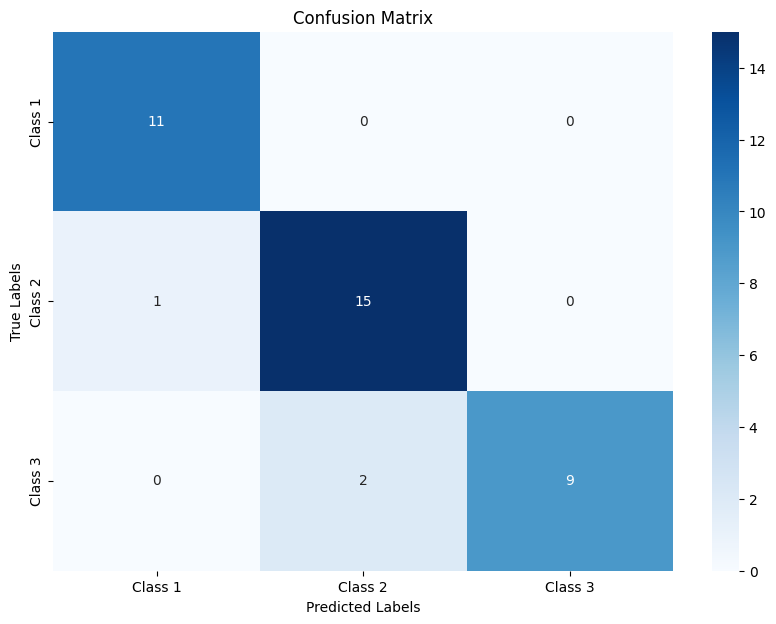

Inception Confusion Matrix:


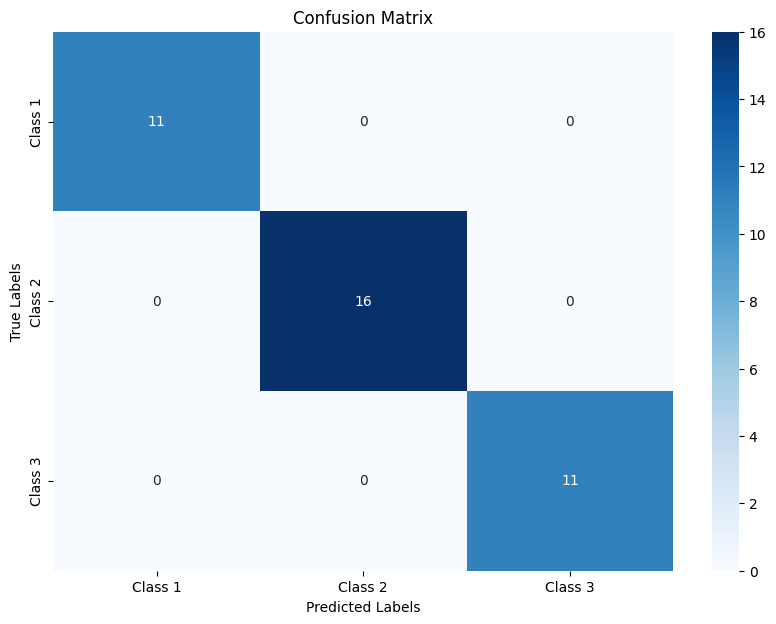

In [ ]:
# Generate confusion matrices
cm_cnn = confusion_matrix(y_true, preds_cnn)
cm_inc = confusion_matrix(y_true, preds_inc)

# Define the plotting function
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.show()

# Assuming `class_names` is a list of your class names
class_names = ['Class 1', 'Class 2', 'Class 3']

# Plot confusion matrices
print("CNN Confusion Matrix:")
plot_confusion_matrix(cm_cnn, class_names)
print("Inception Confusion Matrix:")
plot_confusion_matrix(cm_inc, class_names)

### Bounding Box Prediction Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize lists to store true bounding boxes and test data
y_true = []
X_test = []

# Iterate through the test dataset to extract true bounding boxes and images
for X, y in test_dataset:
    y_true.append(y['bbox'].numpy())  # Append true bounding boxes
    X_test.append(X.numpy())  # Append images

# Concatenate the lists into numpy arrays
X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

# Predict bounding boxes using the CNN model
preds_cnn = cnn_model.predict(X_test, verbose=0)['bbox']

# Predict bounding boxes using the Inception model
preds_inc = inc_model.predict(X_test, verbose=0)['bbox']

# Compute Mean Squared Error (MSE) and Mean Absolute Error (MAE) for CNN Model
mse_cnn = mean_squared_error(y_true, preds_cnn)
mae_cnn = mean_absolute_error(y_true, preds_cnn)
print(f"MSE for CNN Model: {mse_cnn}")
print(f"MAE for CNN Model: {mae_cnn}")

# Compute Mean Squared Error (MSE) and Mean Absolute Error (MAE) for Inception Model
mse_inc = mean_squared_error(y_true, preds_inc)
mae_inc = mean_absolute_error(y_true, preds_inc)
print(f"MSE for Inception Model: {mse_inc}")
print(f"MAE for Inception Model: {mae_inc}")


MSE for CNN Model: 0.039588217969857856
MAE for CNN Model: 0.1719460818424077
MSE for Inception Model: 0.029785153656635917
MAE for Inception Model: 0.1401896277452817


Original Image with Bounding Box:
Bounding box coordinates: x1=73, y1=36, x2=149, y2=186


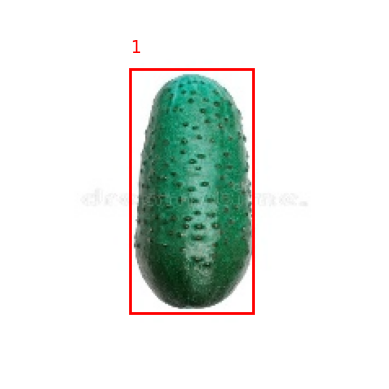


-------------

Standard CNN Predictions:
Bounding box coordinates: x1=0, y1=0, x2=227, y2=227


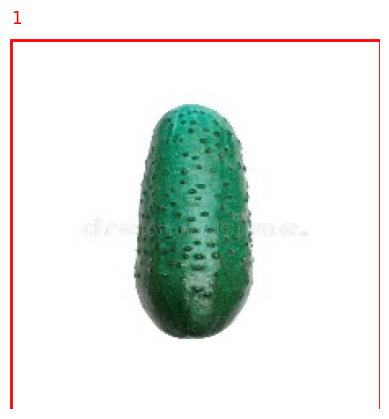


-------------

Inception Predictions:
Bounding box coordinates: x1=0, y1=44, x2=224, y2=191


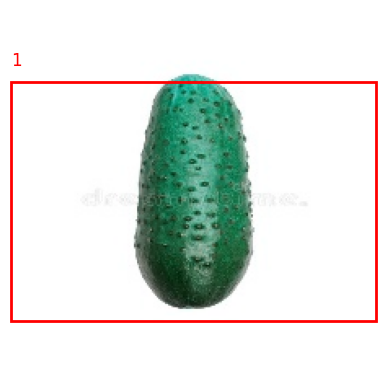

In [ ]:
import random

# Randomly select an example from your scaled dataset
n = random.randint(0, len(images_scaled) - 1)
example_image = images_scaled[n]
example_bbox = bbox_scaled[n]
example_label = labels[n]
example_data = load_and_preprocess_data([example_image], [example_bbox], [example_label], batch_size=1)

# Predict using the Inception model
inc_preds = inc_model.predict(example_data, verbose=0)
[inc_pred_bbox] = inc_preds['bbox']
[inc_pred_label] = inc_preds['label']

# Predict using the CNN model
cnn_preds = cnn_model.predict(example_data, verbose=0)
[cnn_pred_bbox] = cnn_preds['bbox']
[cnn_pred_label] = cnn_preds['label']

# Visualize the example with original and predicted bounding boxes
print("Original Image with Bounding Box:")
plot_image_with_bbox(example_image, example_bbox, example_label)

print("\n-------------\n\nStandard CNN Predictions:")
plot_image_with_bbox(example_image, cnn_pred_bbox, np.argmax(cnn_pred_label[0]) + 1)

print("\n-------------\n\nInception Predictions:")
plot_image_with_bbox(example_image, inc_pred_bbox, np.argmax(inc_pred_label[0]) + 1)

To conclude, we can see how both models perform quite well.
We can see how the Inception Layer performs slightly better, even if it still has some issues in detecting the correct Bounding Box.